In [1]:
from Triangle.Constants import * 
from Triangle.FFTTools import *
from Triangle.Orbit import * 
from Triangle.TDI import *
from Triangle.TDIFly import * 

import matplotlib.pyplot as plt 
import numpy as np 
from tqdm import tqdm 
import h5py

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


no cupy 


## Data

## Print file structure 
This function is generated by AI. 

In [2]:
from typing import Optional

def print_hdf5_structure(obj, indent: int = 0, path: str = "/",
                         show_data: bool = False, max_items: int = 5,
                         max_depth: Optional[int] = None,
                         current_depth: int = 0) -> None:
    if max_depth is not None and current_depth > max_depth:
        return
    
    indent_str = "  " * indent
    
    if isinstance(obj, h5py.File):
        print(f"{indent_str}📁 File: {obj.filename}")
        print(f"{indent_str}  Mode: {obj.mode}")
    elif isinstance(obj, h5py.Group):
        print(f"{indent_str}📁 Group: {path}")
    elif isinstance(obj, h5py.Dataset):
        print(f"{indent_str}📊 Dataset: {path}")
        print(f"{indent_str}  Shape: {obj.shape}")
        print(f"{indent_str}  Dtype: {obj.dtype}")
        print(f"{indent_str}  Size: {obj.size} elements")
        
        if show_data:
            try:
                data = obj[()]
                if isinstance(data, np.ndarray):
                    if data.size <= max_items:
                        print(f"{indent_str}  Data: {data}")
                    else:
                        # 显示前几个和后几个元素
                        flat_data = data.flatten()
                        preview = np.concatenate([
                            flat_data[:max_items//2],
                            flat_data[-max_items//2:]
                        ])
                        print(f"{indent_str}  Data (first & last {max_items//2}): {preview} ...")
                else:
                    print(f"{indent_str}  Data: {data}")
            except Exception as e:
                print(f"{indent_str}  Error reading data: {e}")
    
    # 如果是组或文件，递归遍历其内容
    if isinstance(obj, (h5py.File, h5py.Group)):
        for key in obj.keys():
            new_path = f"{path}/{key}" if path != "/" else f"/{key}"
            try:
                new_obj = obj[key]
                print_hdf5_structure(
                    new_obj, indent + 1, new_path, 
                    show_data, max_items, max_depth, current_depth + 1
                )
            except Exception as e:
                print(f"{indent_str}  ❌ Error accessing {key}: {e}")

In [ ]:
h5f = h5py.File("/Users/taijidatacenter/Downloads/LDCData/LDC2_sangria_training_v2.h5", "r") # path to your LDC data file 
print_hdf5_structure(h5f)

📁 File: /Users/taijidatacenter/Downloads/LDCData/LDC2_sangria_training_v2.h5
  Mode: r
  📁 Group: /header
    📊 Dataset: /header/date
      Shape: ()
      Dtype: object
      Size: 1 elements
  📁 Group: /instru
    📁 Group: /instru/config
      📊 Dataset: /instru/config/LISA_AAFILTER_ATTENUATION
        Shape: ()
        Dtype: int64
        Size: 1 elements
      📊 Dataset: /instru/config/LISA_AAFILTER_TRANSITION_BAND_0
        Shape: ()
        Dtype: float64
        Size: 1 elements
      📊 Dataset: /instru/config/LISA_AAFILTER_TRANSITION_BAND_1
        Shape: ()
        Dtype: float64
        Size: 1 elements
      📊 Dataset: /instru/config/LISA_ACC_NOISE_A_LEVEL
        Shape: ()
        Dtype: float64
        Size: 1 elements
      📊 Dataset: /instru/config/LISA_ACC_NOISE_F_KNEE
        Shape: ()
        Dtype: float64
        Size: 1 elements
      📊 Dataset: /instru/config/LISA_ACC_NOISE_USE_PZM
        Shape: ()
        Dtype: bool
        Size: 1 elements
      📊 Dataset: /i

### Convert to time-domain TDI-AET data

In [4]:
# GB_TYPE = "vgb"
# GB_TYPE = "igb"
GB_TYPE = "dgb"

data_time = np.array(h5f["sky"][GB_TYPE]["tdi"]["t"])[:, 0]
data_a, data_e, data_t = AETfromXYZ(
    h5f["sky"][GB_TYPE]["tdi"]["X"], 
    h5f["sky"][GB_TYPE]["tdi"]["Y"],
    h5f["sky"][GB_TYPE]["tdi"]["Z"]
)
data_channels_td = np.array([data_a, data_e, data_t])[:, :, 0]
channel_names = ["A", "E", "T"]

data_time.shape, data_channels_td.shape

((6307200,), (3, 6307200))

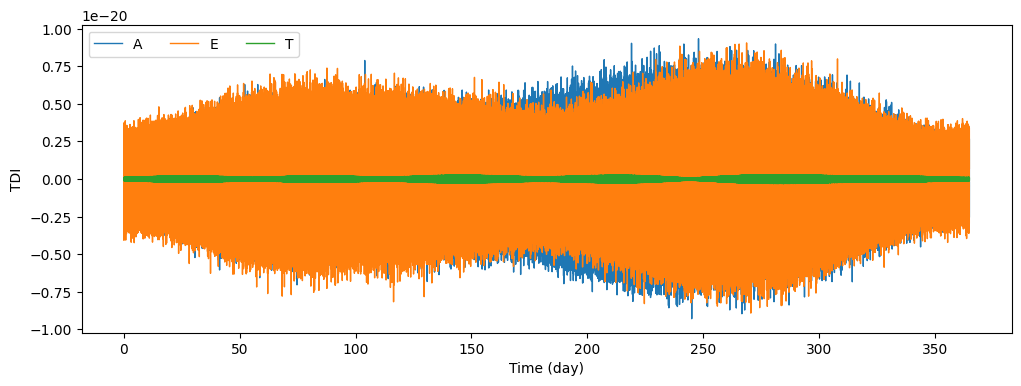

In [5]:
plt.figure(figsize=(12, 4))
for i in range(len(data_channels_td)):
    plt.plot(data_time/DAY, data_channels_td[i], label=channel_names[i], linewidth=1)
plt.xlabel("Time (day)")
plt.ylabel("TDI")
plt.legend(loc="upper left", ncols=3)

### Convert to frequency-domain TDI-AE data
Drop TDI-T channel which is usually not used for signal analysis. 

In [6]:
data_channels_fd = []
for i in range(len(data_channels_td)-1):
    ff, xf = FFT_window(
        data_array=data_channels_td[i], 
        fsample=1./(data_time[1]-data_time[0]), 
        window_type="tukey", 
        window_args_dict=dict(alpha=10000/(data_time[-1]-data_time[0]))
    )
    data_channels_fd.append(xf)
data_frequency = ff 
data_channels_fd = np.array(data_channels_fd)

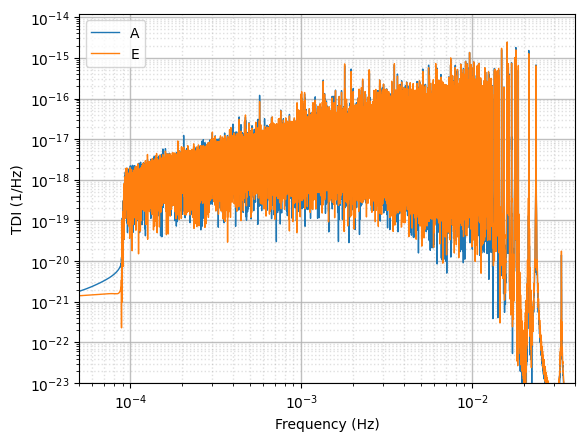

In [7]:
for i in range(len(data_channels_fd)):
    plt.loglog(data_frequency, np.abs(data_channels_fd[i]), label=channel_names[i], linewidth=1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("TDI (1/Hz)")
plt.xlim(5e-5, 4e-2)
plt.ylim(1e-23,)
plt.grid(which="major", linewidth=1, linestyle="-", alpha=0.8)
plt.grid(which="minor", linewidth=1, linestyle=":", alpha=0.4)
plt.legend(loc="upper left")

### Load parameters 

In [8]:
h5f["sky"][GB_TYPE]["cat"][...].dtype

dtype([('Name', '<i8'), ('Amplitude', '<f8'), ('EclipticLatitude', '<f8'), ('EclipticLongitude', '<f8'), ('Frequency', '<f8'), ('FrequencyDerivative', '<f8'), ('Inclination', '<f8'), ('InitialPhase', '<f8'), ('Polarization', '<f8')])

In [9]:
gb_parameters = {
    "A": list(), 
    "f0": list(), 
    "fdot0": list(), 
    "phase0": list(), 
    "inclination": list(), 
    "longitude": list(), 
    "latitude": list(), 
    "psi": list()
}

try: 
    gb_parameter_array = np.loadtxt("./"+GB_TYPE+"_parameters.txt")
    for ikey, key in enumerate(gb_parameters.keys()):
        gb_parameters[key] = gb_parameter_array[:, ikey]
except:
    if GB_TYPE == "vgb": 
        for i in tqdm(range(len(h5f["sky"][GB_TYPE]["cat"]))): 
            gb_parameters["A"].append(h5f["sky"][GB_TYPE]["cat"][i][0][1])
            gb_parameters["latitude"].append(h5f["sky"][GB_TYPE]["cat"][i][0][4])
            gb_parameters["longitude"].append(h5f["sky"][GB_TYPE]["cat"][i][0][5])
            gb_parameters["f0"].append(h5f["sky"][GB_TYPE]["cat"][i][0][9])
            gb_parameters["fdot0"].append(h5f["sky"][GB_TYPE]["cat"][i][0][10])
            gb_parameters["inclination"].append(h5f["sky"][GB_TYPE]["cat"][i][0][13])
            gb_parameters["phase0"].append(h5f["sky"][GB_TYPE]["cat"][i][0][14])
            gb_parameters["psi"].append(h5f["sky"][GB_TYPE]["cat"][i][0][18])
    elif GB_TYPE == "igb" or GB_TYPE == "dgb": 
        for i in tqdm(range(len(h5f["sky"][GB_TYPE]["cat"]))): 
            gb_parameters["A"].append(h5f["sky"][GB_TYPE]["cat"][i][0][1])
            gb_parameters["latitude"].append(h5f["sky"][GB_TYPE]["cat"][i][0][2])
            gb_parameters["longitude"].append(h5f["sky"][GB_TYPE]["cat"][i][0][3])
            gb_parameters["f0"].append(h5f["sky"][GB_TYPE]["cat"][i][0][4])
            gb_parameters["fdot0"].append(h5f["sky"][GB_TYPE]["cat"][i][0][5])
            gb_parameters["inclination"].append(h5f["sky"][GB_TYPE]["cat"][i][0][6])
            gb_parameters["phase0"].append(h5f["sky"][GB_TYPE]["cat"][i][0][7])
            gb_parameters["psi"].append(h5f["sky"][GB_TYPE]["cat"][i][0][8])
        
    for k, v in gb_parameters.items():
        gb_parameters[k] = np.array(v)
        
    np.savetxt(
        fname="./"+GB_TYPE+"_parameters.txt", 
        X=np.array(list(gb_parameters.values())).T, 
        header="'A', 'f0', 'fdot0', 'phase0', 'inclination', 'longitude', 'latitude', 'psi'", 
    )


100%|██████████| 26000000/26000000 [5:23:34<00:00, 1339.23it/s]  


### From LDC to TDC parametrization
$\psi \rightarrow \psi - \pi/2, \varphi_0 \rightarrow -\varphi_0$

In [10]:
gb_parameters["psi"] += PI / 2. 
gb_parameters["phase0"] *= -1.

## Slice data in a small frequency bin 

In [11]:
gb_idx = np.argmin(np.abs(gb_parameters["f0"]-4e-3))
FCENTER = gb_parameters["f0"][gb_idx]
FMIN = FCENTER-5e-6
FMAX = FCENTER+5e-6

source_idx = np.where((gb_parameters["f0"]<FMAX)&(gb_parameters["f0"]>FMIN))[0]
gb_parameters_in_bin = dict() 
for k, v in gb_parameters.items(): 
    gb_parameters_in_bin[k] = v[source_idx]
print("center of bin (mHz):", FCENTER*1e3)
print("number of GBs in bin:", len(gb_parameters_in_bin["A"]))

center of bin (mHz): 4.0001634350846995
number of GBs in bin: 39


In [12]:
data_idx = np.where((data_frequency>FMIN)&(data_frequency<FMAX))[0]
data_frequency_in_bin = data_frequency[data_idx]
data_channels_fd_in_bin = data_channels_fd[:, data_idx]

data_frequency_in_bin.shape, data_channels_fd_in_bin.shape

((315,), (2, 315))

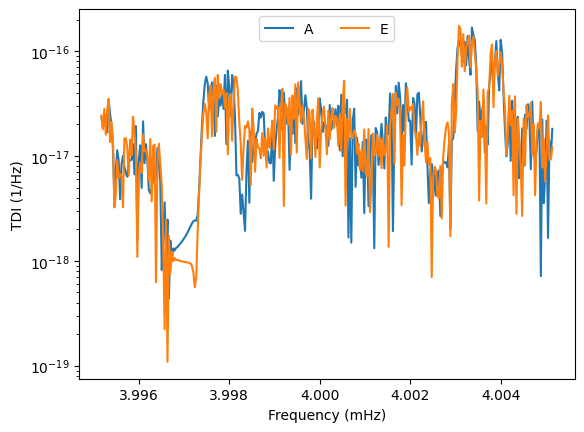

In [13]:
for i in range(len(data_channels_fd_in_bin)):
    plt.semilogy(data_frequency_in_bin*1e3, np.abs(data_channels_fd_in_bin[i]), label=channel_names[i])
plt.xlabel("Frequency (mHz)")
plt.ylabel("TDI (1/Hz)")
plt.legend(loc="upper center", ncols=2)

## GB response of ``Triangle``

### response model

In [14]:
# TDI channel 
X_string = { 
    "12": [(-1., []), (1., ["13", "31"])],
    "23": [], 
    "31": [(1., ["13"]), (-1., ["12", "21", "13"])], 
    "21": [(-1., ["12"]), (1., ["13", "31", "12"])],
    "32": [], 
    "13": [(1., []), (-1., ["12", "21"])],
}
Y_string = TDIStringManipulation.TDIStringCyc(X_string)
Z_string = TDIStringManipulation.TDIStringCyc(Y_string)

# detector orbit 
orbit = Orbit(
    OrbitDir="./LDCEqualArmOrbit", 
    dt=DAY, 
    pn_order=0,
)

# response generator 
gb_response_generator = TDIFlyGB(
    orbit=orbit, 
    Pstring_list=[X_string,Y_string,Z_string], 
    tcb_times=data_time.copy(), 
    # Nsparse=2048,
)

### generate response 

In [15]:
res_xyz = gb_response_generator(
    parameters=gb_parameters_in_bin, 
    domain="frequency", 
)
res_ae = gb_response_generator.XYZtoAE(res_xyz)
template_in_bin = gb_response_generator.fill_fftseries(
    data=res_ae, 
    start_idx=gb_response_generator.start_idx, 
    StartBound=data_idx[0]+1, 
    EndBound=data_idx[-1]+1, 
)
template_in_bin = np.sum(template_in_bin, axis=1)
template_in_bin.shape, data_frequency_in_bin.shape

((2, 315), (315,))

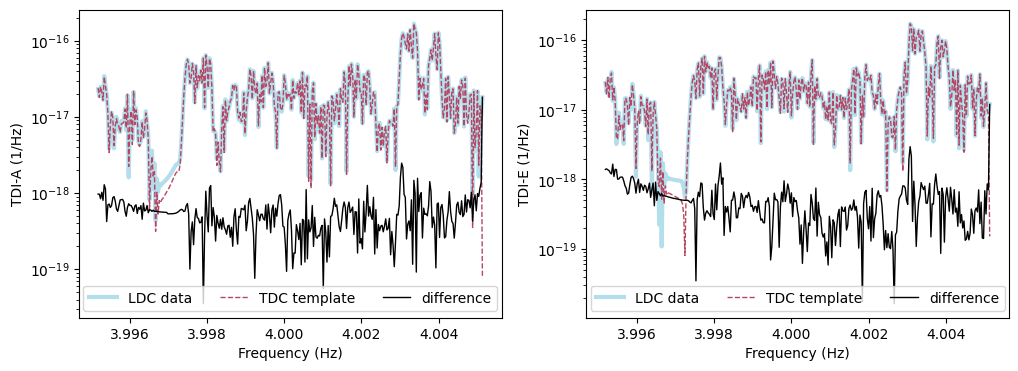

In [16]:
plt.figure(figsize=(12, 4))
for i in range(len(data_channels_fd_in_bin)):
    plt.subplot(121+i)
    plt.semilogy(data_frequency_in_bin * 1e3, np.abs(data_channels_fd_in_bin[i]), linewidth=3, color=BLUE, alpha=0.5, label="LDC data")
    plt.semilogy(data_frequency_in_bin * 1e3, np.abs(template_in_bin[i]), linewidth=1, color=RED, linestyle="--", label="TDC template")
    plt.semilogy(data_frequency_in_bin * 1e3, np.abs(data_channels_fd_in_bin[i] - template_in_bin[i]), linewidth=1, color="k", label="difference")
    plt.legend(loc="lower center", ncols=3)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("TDI-"+channel_names[i]+" (1/Hz)")
